# Congestion Finder | Integration Example

This Notebook goes through all the steps of the _congestion finder_ module, with exception of the database connections. Each step builds on the output of the previous step. Therefore, this **Congestion Finder | Integration Example** documents the integration of all classes and functions in the module. Together with the **Congestion Finder | Unit Example**, it serves as documentation for the module, both to allow users and developers to get familiar with the code.

## Initialization

Tho initialize the module, several properties need to be set and modules need to be imported.

### Properties

Usually, the properties are set using a _properties file_. Here, we will define the directly.

In [1]:
date = "20171120"
roadNumber = 2
roadsFileName = "../tests/data/BPS_20171120.txt"
detectionsFileName = "../tests/data/A2_20171120.txt"
outputDirectory = "../tests/data"
speedThreshold = 65
flowThreshold = 40
spaceSmoothing = 10
timeSmoothing = 20
marginSpace = spaceSmoothing  # probably always the same
marginTime = timeSmoothing  # probably always the same

### Imports

The following list of modules need to be imported. 

In [2]:
import logging

import numpy
import matplotlib.pyplot

import sys
sys.path.append("../")
import congestionfinder
import congestionfinder.bpsdetector
import congestionfinder.road
import congestionfinder.detection
import congestionfinder.speedflow
import congestionfinder.congestion
import patchfinder.patch

### Logging

During this example, we will log at _debug_ level, to get the most information about the code. We will include the time at the millisecond level, so that we can see the process time of each step.

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(formatter)
logger.addHandler(consoleHandler)

## Roads

The first step to find congestion is to load the road network. This is done by obtaining the list of all active BPS detectors. In this example, we first read a list of BPS codes from a CSV file. We print the list of codes, which are strings of 20 hexadecimal characters.

In [4]:
bpsCodes = congestionfinder.bpsdetector.readCSVToBPSCodes(roadsFileName)

2017-12-18 14:53:23,680 - DEBUG - Starting readCSVToBPSCodes()
2017-12-18 14:53:23,711 - DEBUG - Ending readCSVToBPSCodes()


In [5]:
for bpsCode in bpsCodes:
    print(bpsCode)

10D00100A055D0070007
10D00100A055D007000B
10D00100A055D007000F
10D00100B85ED0070007
10D00100B85ED007000B
10D00100B85ED007000F
10D00100D05CD0070007
10D00100D05CD007000B
10D00100D05CD007000F
10D00100D05CD0070013
10D00100D05CD0070017
10D00100DC02D0070007
10D00100DC02D007000B
10D00100DC02D007000F
10D00100DC02D0070013
10D00100DC02D0070017
10D00100F41AD0070007
10D00100F41AD007000B
10D00100F41AD007000F
10D00100F41AD0070013
10D001010049D0070007
10D001010049D007000B
10D001010049D007000F
10D001010049D0070013
10D001011805D0070007
10D001011805D007000B
10D001011805D007000F
10D001011805D0070013
10D001011C62D007000B
10D001011C62D007000F
10D001011C62D0070013
10D001011C62D0070017
10D001012C00D0070007
10D001012C00D007000B
10D001012C00D007000F
10D001012C00D0070013
10D001012C00D0070307
10D001012C00D007030B
10D001013800D0070007
10D001013800D007000B
10D001013800D007000F
10D001013800D0070013
10D001013800D0070307
10D001013800D007030B
10D001014063D0070007
10D001014063D007000B
10D001014063D007000F
10D001014063D

10D00408E832D007000B
10D00408F419D0070007
10D00408F419D007000B
10D004090C4BD0070007
10D004090C4BD007000B
10D004091C2CD0070007
10D004091C2CD007000B
10D004093014D0070007
10D004093014D007000B
10D004094046D0070007
10D004094046D007000B
10D004095414D0070007
10D004095414D007000B
10D004096844D0070007
10D004096844D007000B
10D004097800D0070007
10D004097800D007000B
10D004098437D0070007
10D004098437D007000B
10D004098437D0070087
10D004098C42D0070007
10D004098C42D007000B
10D004098C42D0070087
10D004099441D0070007
10D004099441D007000B
10D004099441D0070087
10D004099C37D0070007
10D004099C37D007000B
10D004099C37D0070087
10D00409A05AD0070007
10D00409A05AD007000B
10D00409A05AD0070087
10D00409A819D0070007
10D00409A819D007000B
10D00409A819D0070087
10D00409AC50D0070007
10D00409AC50D007000B
10D00409AC50D0070087
10D00409B423D0070007
10D00409B423D007000B
10D00409B423D0070087
10D00409BC00D0070007
10D00409BC00D007000B
10D00409BC00D0070087
10D00409C044D0070007
10D00409C044D007000B
10D00409C044D0070087
10D00409C800D

10D00E01DC4ED007000B
10D00E01E80DD0070007
10D00E01E80DD007000B
10D00E01F01BD0070007
10D00E01F01BD007000B
10D00E01F415D0070007
10D00E01F415D007000B
10D00E01F813D0070007
10D00E01F813D007000B
10D00E01FC27D0070007
10D00E01FC27D007000B
10D00E02001BD0070007
10D00E02001BD007000B
10D00E020062D0070007
10D00E020062D007000B
10D00E021029D0070007
10D00E021029D007000B
10D00E021431D0070007
10D00E021431D007000B
10D00E022409D0070007
10D00E022409D007000B
10D00E022806D0070007
10D00E022806D007000B
10D00E022C39D0070007
10D00E022C39D007000B
10D00E023407D0070007
10D00E023407D007000B
10D00E023839D0070007
10D00E023839D007000B
10D00E024007D0070007
10D00E024007D007000B
10D00E02443AD0070007
10D00E02443AD007000B
10D00E024C32D0070007
10D00E024C32D007000B
10D00F033841D0070007
10D00F033841D007000B
10D00F034C00D0070007
10D00F034C00D007000B
10D00F035C0AD0070007
10D00F035C0AD007000B
10D00F03645FD0070007
10D00F03645FD007000B
10D00F03645FD0070107
10D00F03740AD0070007
10D00F03740AD007000B
10D00F038014D0070007
10D00F038014D

10D020010841D0070307
10D020012041D0070007
10D020012041D007000B
10D020013432D0070007
10D020013432D007000B
10D023051434D0070007
10D023052000D0070007
10D023052430D0070007
10D023053037D0070007
10D02305380ED0070007
10D023053C51D0070007
10D023055017D0070007
10D023056020D0070007
10D023081014D0070007
10D023081014D007000B
10D02308243CD0070007
10D02308243CD007000B
10D023083455D0070007
10D023083455D007000B
10D023083455D0070307
10D023084C14D0070007
10D023084C14D007000B
10D023084C14D0070307
10D023086414D0070007
10D023086414D007000B
10D023086414D0070307
10D023087819D0070007
10D023087819D007000B
10D023087819D007000F
10D023089014D0070007
10D023089014D007000B
10D02308A453D0070007
10D02308A453D007000B
10D02308A453D0070107
10D026032032D0070007
10D026032032D007000B
10D026033432D0070007
10D026033432D007000B
10D02C001800D0070007
10D02C001800D007000B
10D02C001C19D0070007
10D02C001C19D007000B
10D02C002000D0070007
10D02C002000D007000B
10D02C003800D0070007
10D02C003800D007000B
10D02C003800D0070307
10D02C004C28D

The BPS codes can be parsed to a new class called _Road_. To find out more about this class, please look at the **Congestion Finder | Unit Example** Notebook. We print the list of all roads, sorted by its number of detectors.

In [6]:
roads = congestionfinder.road.parseBPSCodesToRoads(bpsCodes)

2017-12-18 14:53:24,476 - DEBUG - Starting parseBPSCodesToRoads()
2017-12-18 14:53:24,508 - DEBUG - Ending parseBPSCodesToRoads()


In [7]:
for value in sorted(roads.values(), key = lambda x:len(x.getBPSDetectors())):
    print(value)

roadNumber: 205 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 1
roadNumber: 30 | len(bpsDetectors): 2 | len(spaceToSpaceIndex): 1
roadNumber: 38 | len(bpsDetectors): 4 | len(spaceToSpaceIndex): 2
roadNumber: 11 | len(bpsDetectors): 6 | len(spaceToSpaceIndex): 3
roadNumber: 242 | len(bpsDetectors): 7 | len(spaceToSpaceIndex): 3
roadNumber: 783 | len(bpsDetectors): 7 | len(spaceToSpaceIndex): 3
roadNumber: 79 | len(bpsDetectors): 8 | len(spaceToSpaceIndex): 3
roadNumber: 32 | len(bpsDetectors): 10 | len(spaceToSpaceIndex): 4
roadNumber: 65 | len(bpsDetectors): 12 | len(spaceToSpaceIndex): 6
roadNumber: 208 | len(bpsDetectors): 12 | len(spaceToSpaceIndex): 6
roadNumber: 222 | len(bpsDetectors): 17 | len(spaceToSpaceIndex): 7
roadNumber: 44 | len(bpsDetectors): 20 | len(spaceToSpaceIndex): 9
roadNumber: 35 | len(bpsDetectors): 29 | len(spaceToSpaceIndex): 16
roadNumber: 59 | len(bpsDetectors): 31 | len(spaceToSpaceIndex): 16
roadNumber: 73 | len(bpsDetectors): 35 | len(spaceToSpaceIndex

As we will concentrate on a single road in the example, we define the variable _road_ here for future use.

In [8]:
road = roads[roadNumber]

## Speed and Flows

In [9]:
detections = congestionfinder.detection.readCSVToDetections(detectionsFileName)

2017-12-18 14:53:24,633 - DEBUG - Starting readCSVToDetections()
2017-12-18 14:53:33,101 - DEBUG - Ending readCSVToDetections()


In [10]:
iterator = iter(detections)
for i in range(min(len(detections), 300)):
    detection = next(iterator)
    print(detection)

code: 10D00225B43CD007000B | space: 241360 | time: 76 | speed: 90 | flow: 0.5
code: 10D002117C2DD007000B | space: 111945 | time: 854 | speed: 104 | flow: 14.0
code: 10D0021B8832D007000B | space: 176250 | time: 208 | speed: 86 | flow: 0.5
code: 10D00224B805D007000B | space: 235005 | time: 1261 | speed: 116 | flow: 9.5
code: 10D002117C2DD007000B | space: 111945 | time: 855 | speed: 108 | flow: 20.0
code: 10D0021B8832D007000B | space: 176250 | time: 138 | speed: 127 | flow: 0.5
code: 10D002239032D007000B | space: 227650 | time: 1086 | speed: 105 | flow: 24.0
code: 10D002117C2DD007000B | space: 111945 | time: 784 | speed: 111 | flow: 13.0
code: 10D0021ADC30D007000F | space: 171948 | time: 204 | speed: 89 | flow: 1.6666666666666667
code: 10D0021B8832D007000B | space: 176250 | time: 209 | speed: 118 | flow: 2.0
code: 10D002117C2DD007000B | space: 111945 | time: 785 | speed: 111 | flow: 15.0
code: 10D0021B8832D007000B | space: 176250 | time: 139 | speed: 121 | flow: 1.0
code: 10D00225B43CD007

In [11]:
speeds, flows, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex = congestionfinder.speedflow.parseDetectionsToSpeedsAndFlows(detections, road)

2017-12-18 14:53:33,148 - DEBUG - Starting parseDetectionsToSpeedFlows()
2017-12-18 14:53:33,805 - DEBUG - Ending parseDetectionsToSpeedFlows()


(432, 1440)
(432, 1440)
0
431
0
1439


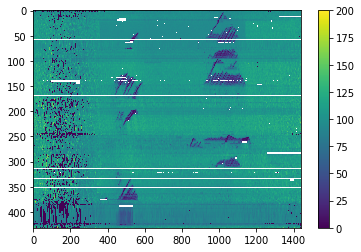

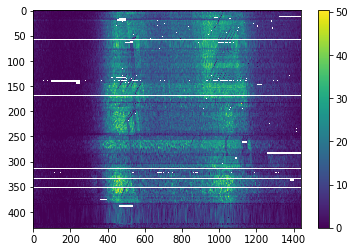

In [12]:
print(speeds.shape)
print(flows.shape)
print(minSpaceIndex)
print(maxSpaceIndex)
print(minTimeIndex)
print(maxTimeIndex)
matplotlib.pyplot.imshow(speeds, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flows, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [13]:
speedsWorkingDetectors, flowsWorkingDetectors, maskWorkingDetectors = congestionfinder.speedflow.removeMissingDetectors(speeds, flows) ## Do something with Mask

2017-12-18 14:53:34,367 - DEBUG - Starting removeMissingDetectors()
2017-12-18 14:53:34,367 - DEBUG - Ending removeMissingDetectors()


(419, 1440)
(419, 1440)
0.969907407407


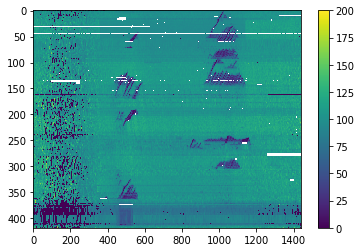

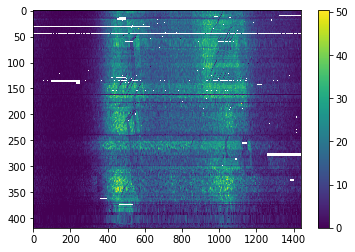

In [14]:
print(speedsWorkingDetectors.shape)
print(flowsWorkingDetectors.shape)
print(sum(maskWorkingDetectors) / (sum(maskWorkingDetectors) + sum(~maskWorkingDetectors)))
matplotlib.pyplot.imshow(speedsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [15]:
speedsHighFlow, flowsHighFlow, maskHighFlow = congestionfinder.speedflow.removeLowFlowTimes(speedsWorkingDetectors, flowsWorkingDetectors) ## Do something with Mask

2017-12-18 14:53:34,899 - DEBUG - Starting removeLowFlowTimes()
2017-12-18 14:53:34,914 - DEBUG - Ending removeLowFlowTimes()


(419, 806)
(419, 806)
0.559722222222


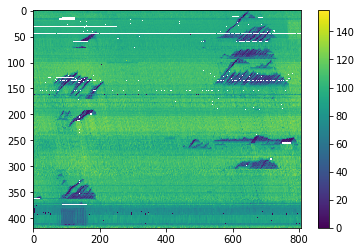

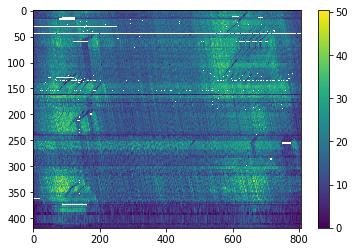

In [16]:
print(speedsHighFlow.shape)
print(flowsHighFlow.shape)
print(sum(maskHighFlow) / (sum(maskHighFlow) + sum(~maskHighFlow)))
matplotlib.pyplot.imshow(speedsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

## Congestion

In [17]:
congestions = congestionfinder.congestion.parseSpeedFlowsToCongestions(speedsHighFlow, flowsHighFlow, speedThreshold, flowThreshold)

2017-12-18 14:53:35,430 - DEBUG - Starting parseSpeedFlowsToCongestions()
2017-12-18 14:53:35,430 - DEBUG - Ending parseSpeedFlowsToCongestions()


(419, 806)


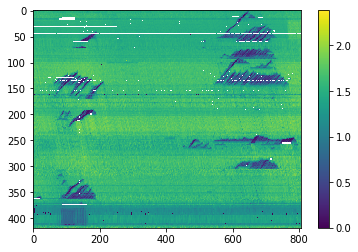

In [18]:
print(congestions.shape)
matplotlib.pyplot.imshow(congestions, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [19]:
congestionsWithoutMissingValues = congestionfinder.congestion.interpolateMissingValues(congestions)

2017-12-18 14:53:35,711 - DEBUG - Starting interpolateMissingValues()
2017-12-18 14:53:47,788 - DEBUG - Ending interpolateMissingValues()


(419, 806)


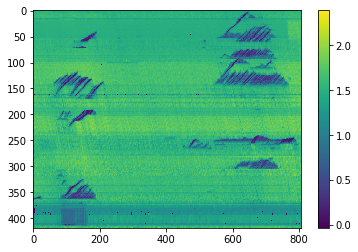

In [20]:
print(congestionsWithoutMissingValues.shape)
matplotlib.pyplot.imshow(congestionsWithoutMissingValues, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [21]:
congestionsSmoothed = congestionfinder.congestion.applySmoothingFilter(congestionsWithoutMissingValues, spaceSmoothing, timeSmoothing)

2017-12-18 14:53:47,991 - DEBUG - Starting applySmoothingFilter()
2017-12-18 14:53:47,991 - DEBUG - Ending applySmoothingFilter()


(419, 806)


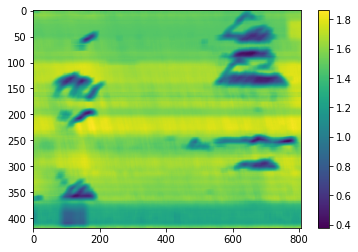

In [22]:
print(congestionsSmoothed.shape)
matplotlib.pyplot.imshow(congestionsSmoothed, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

## Congestion Patch Finder

In [23]:
congestionsBoolean = congestionsSmoothed < 1

In [24]:
congestionPatches = patchfinder.patch.findPatches(congestionsBoolean)

2017-12-18 14:53:48,241 - DEBUG - Starting findPatches()
2017-12-18 14:53:48,241 - DEBUG - Direction: 0
2017-12-18 14:53:48,241 - DEBUG - Starting scanForBoundaries()
2017-12-18 14:53:48,256 - DEBUG - Found start: 77
2017-12-18 14:53:48,256 - DEBUG - Found stop: 193
2017-12-18 14:53:48,256 - DEBUG - Found start: 480
2017-12-18 14:53:48,256 - DEBUG - Found stop: 491
2017-12-18 14:53:48,256 - DEBUG - Found start: 557
2017-12-18 14:53:48,256 - DEBUG - Found stop: 786
2017-12-18 14:53:48,256 - DEBUG - Ending scanForBoundaries()
2017-12-18 14:53:48,256 - DEBUG - Found patches: [[0, 418, 77, 193], [0, 418, 480, 491], [0, 418, 557, 786]]
2017-12-18 14:53:48,256 - DEBUG - length: 3| parentLength: 0
2017-12-18 14:53:48,256 - DEBUG - Scanning children...
2017-12-18 14:53:48,272 - DEBUG - Child: 0
2017-12-18 14:53:48,272 - DEBUG -   Starting findPatches()
2017-12-18 14:53:48,272 - DEBUG -   Direction: 1
2017-12-18 14:53:48,272 - DEBUG -   Starting scanForBoundaries()
2017-12-18 14:53:48,272 - DEB

2017-12-18 14:53:48,397 - DEBUG -       Ending scanForBoundaries()
2017-12-18 14:53:48,397 - DEBUG -       Found patches: [[381, 413, 84, 158]]
2017-12-18 14:53:48,397 - DEBUG -       length: 1| parentLength: 1
2017-12-18 14:53:48,397 - DEBUG -       Done: xStart: 381 | xEnd: 413 | yStart: 84 | yEnd: 158
2017-12-18 14:53:48,397 - DEBUG -       Ending findPatches()
2017-12-18 14:53:48,397 - DEBUG -     Ending findPatches()
2017-12-18 14:53:48,397 - DEBUG -   Ending findPatches()
2017-12-18 14:53:48,397 - DEBUG - Child: 1
2017-12-18 14:53:48,397 - DEBUG -   Starting findPatches()
2017-12-18 14:53:48,397 - DEBUG -   Direction: 1
2017-12-18 14:53:48,413 - DEBUG -   Starting scanForBoundaries()
2017-12-18 14:53:48,413 - DEBUG -   Found start: 250
2017-12-18 14:53:48,413 - DEBUG -   Found stop: 255
2017-12-18 14:53:48,413 - DEBUG -   Ending scanForBoundaries()
2017-12-18 14:53:48,413 - DEBUG -   Found patches: [[250, 255, 480, 491]]
2017-12-18 14:53:48,413 - DEBUG -   length: 1| parentLength

2017-12-18 14:53:48,538 - DEBUG -       length: 1| parentLength: 1
2017-12-18 14:53:48,538 - DEBUG -       Done: xStart: 122 | xEnd: 144 | yStart: 557 | yEnd: 752
2017-12-18 14:53:48,538 - DEBUG -       Ending findPatches()
2017-12-18 14:53:48,538 - DEBUG -     Ending findPatches()
2017-12-18 14:53:48,538 - DEBUG -   Child: 4
2017-12-18 14:53:48,538 - DEBUG -     Starting findPatches()
2017-12-18 14:53:48,538 - DEBUG -     Direction: 0
2017-12-18 14:53:48,538 - DEBUG -     Starting scanForBoundaries()
2017-12-18 14:53:48,553 - DEBUG -     Found start: 14
2017-12-18 14:53:48,553 - DEBUG -     Found stop: 48
2017-12-18 14:53:48,553 - DEBUG -     Found start: 53
2017-12-18 14:53:48,553 - DEBUG -     Found stop: 59
2017-12-18 14:53:48,553 - DEBUG -     Found start: 61
2017-12-18 14:53:48,553 - DEBUG -     Found stop at end.
2017-12-18 14:53:48,553 - DEBUG -     Ending scanForBoundaries()
2017-12-18 14:53:48,553 - DEBUG -     Found patches: [[242, 256, 571, 605], [242, 256, 610, 616], [242,

In [25]:
for congestionPatch in congestionPatches:
    print(congestionPatch)

xStart: 46 | xEnd: 61 | yStart: 148 | yEnd: 186
xStart: 124 | xEnd: 169 | yStart: 77 | yEnd: 193
xStart: 192 | xEnd: 213 | yStart: 123 | yEnd: 182
xStart: 338 | xEnd: 363 | yStart: 90 | yEnd: 183
xStart: 381 | xEnd: 413 | yStart: 84 | yEnd: 158
xStart: 250 | xEnd: 255 | yStart: 480 | yEnd: 491
xStart: 9 | xEnd: 22 | yStart: 616 | yEnd: 644
xStart: 33 | xEnd: 60 | yStart: 572 | yEnd: 713
xStart: 75 | xEnd: 106 | yStart: 595 | yEnd: 715
xStart: 122 | xEnd: 144 | yStart: 557 | yEnd: 752
xStart: 250 | xEnd: 253 | yStart: 571 | yEnd: 605
xStart: 251 | xEnd: 251 | yStart: 610 | yEnd: 616
xStart: 242 | xEnd: 256 | yStart: 618 | yEnd: 786
xStart: 289 | xEnd: 304 | yStart: 623 | yEnd: 729


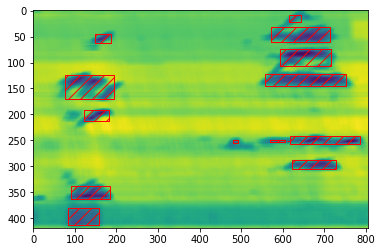

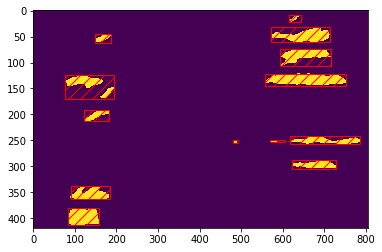

In [26]:
congestionfinder.congestion.plotCongestionsWithPatches(congestionsSmoothed, congestionPatches)
congestionfinder.congestion.plotCongestionsWithPatches(congestionsBoolean, congestionPatches)

In [27]:
congestionPatchesFiltered = patchfinder.patch.filterLargePatches(congestionPatches)

2017-12-18 14:53:49,272 - DEBUG - Starting filterLargePatches()
2017-12-18 14:53:49,272 - DEBUG - Ending filterLargePatches()


In [28]:
for congestionPatch in congestionPatchesFiltered:
    print(congestionPatch)

xStart: 124 | xEnd: 169 | yStart: 77 | yEnd: 193
xStart: 192 | xEnd: 213 | yStart: 123 | yEnd: 182
xStart: 338 | xEnd: 363 | yStart: 90 | yEnd: 183
xStart: 381 | xEnd: 413 | yStart: 84 | yEnd: 158
xStart: 33 | xEnd: 60 | yStart: 572 | yEnd: 713
xStart: 75 | xEnd: 106 | yStart: 595 | yEnd: 715
xStart: 122 | xEnd: 144 | yStart: 557 | yEnd: 752
xStart: 242 | xEnd: 256 | yStart: 618 | yEnd: 786
xStart: 289 | xEnd: 304 | yStart: 623 | yEnd: 729


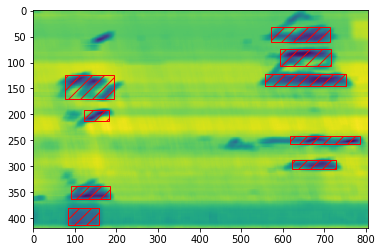

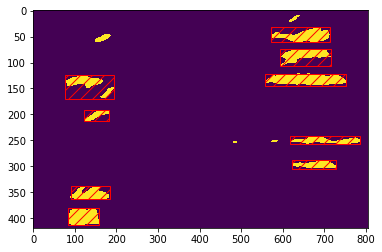

In [29]:
congestionfinder.congestion.plotCongestionsWithPatches(congestionsSmoothed, congestionPatchesFiltered)
congestionfinder.congestion.plotCongestionsWithPatches(congestionsBoolean, congestionPatchesFiltered)

In [30]:
speedFlowPatches = congestionfinder.speedflow.unmaskPatches(congestionPatches, maskWorkingDetectors, maskHighFlow)

2017-12-18 14:53:49,600 - DEBUG - Starting unmaskPatches()
2017-12-18 14:53:49,600 - DEBUG - Ending unmaskPatches()


In [31]:
for speedFlowPatch in speedFlowPatches:
    print(speedFlowPatch)

xStart: 47 | xEnd: 63 | yStart: 522 | yEnd: 560
xStart: 127 | xEnd: 173 | yStart: 451 | yEnd: 567
xStart: 197 | xEnd: 218 | yStart: 497 | yEnd: 556
xStart: 349 | xEnd: 375 | yStart: 464 | yEnd: 557
xStart: 393 | xEnd: 425 | yStart: 458 | yEnd: 532
xStart: 255 | xEnd: 260 | yStart: 854 | yEnd: 865
xStart: 10 | xEnd: 23 | yStart: 990 | yEnd: 1018
xStart: 34 | xEnd: 62 | yStart: 946 | yEnd: 1087
xStart: 78 | xEnd: 109 | yStart: 969 | yEnd: 1089
xStart: 125 | xEnd: 147 | yStart: 931 | yEnd: 1126
xStart: 255 | xEnd: 258 | yStart: 945 | yEnd: 979
xStart: 256 | xEnd: 256 | yStart: 984 | yEnd: 990
xStart: 247 | xEnd: 261 | yStart: 992 | yEnd: 1160
xStart: 294 | xEnd: 309 | yStart: 997 | yEnd: 1103


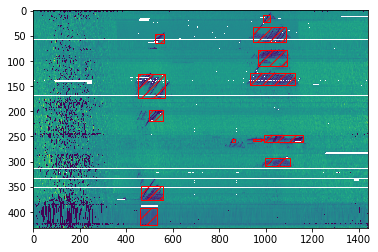

In [32]:
congestionfinder.congestion.plotCongestionsWithPatches(speeds, speedFlowPatches)

In [33]:
speedFlowPatchesWithMargins = congestionfinder.speedflow.addMargins(speedFlowPatches, marginSpace, marginTime, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex)

2017-12-18 14:53:49,850 - DEBUG - Starting addMargins()
2017-12-18 14:53:49,850 - DEBUG - Ending addMargins()


In [34]:
for speedFlowPatch in speedFlowPatchesWithMargins:
    print(speedFlowPatch)

xStart: 37 | xEnd: 73 | yStart: 502 | yEnd: 580
xStart: 117 | xEnd: 183 | yStart: 431 | yEnd: 587
xStart: 187 | xEnd: 228 | yStart: 477 | yEnd: 576
xStart: 339 | xEnd: 385 | yStart: 444 | yEnd: 577
xStart: 383 | xEnd: 431 | yStart: 438 | yEnd: 552
xStart: 245 | xEnd: 270 | yStart: 834 | yEnd: 885
xStart: 0 | xEnd: 33 | yStart: 970 | yEnd: 1038
xStart: 24 | xEnd: 72 | yStart: 926 | yEnd: 1107
xStart: 68 | xEnd: 119 | yStart: 949 | yEnd: 1109
xStart: 115 | xEnd: 157 | yStart: 911 | yEnd: 1146
xStart: 245 | xEnd: 268 | yStart: 925 | yEnd: 999
xStart: 246 | xEnd: 266 | yStart: 964 | yEnd: 1010
xStart: 237 | xEnd: 271 | yStart: 972 | yEnd: 1180
xStart: 284 | xEnd: 319 | yStart: 977 | yEnd: 1123


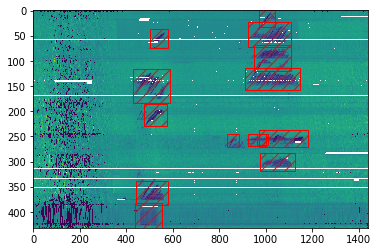

In [35]:
congestionfinder.congestion.plotCongestionsWithPatches(speeds, speedFlowPatchesWithMargins)

In [36]:
congestionfinder.speedflow.writeSpeedsAndFlowsToCSV(speeds, flows, speedFlowPatchesWithMargins, outputDirectory, date, road)

2017-12-18 14:53:50,116 - DEBUG - Starting writeSpeedsAndFlowsToCSV()
2017-12-18 14:53:50,741 - DEBUG - Ending writeSpeedsAndFlowsToCSV()


End of Notebook